
IBM Employee Attrition Analysis

In this project, we will create an XGBoost analysis model that uses employee records to predict whether the employee will leave the company, and use LIME and SHAP to find insights from each prediction result and analysis model. The data below is provided by the IBM Data Science team. Each record in the data records the feature value of the employee, and the target variable Attrition indicates whether the employee left the company (0: working, 1: leaving the company).

In [ ]:
import pandas as pd
import numpy as np
hr = pd.read_csv("/content/HR.csv")

# drop unncessary features
hr = hr.drop(['DailyRate',  # MonthlyIncome contains related info
              'HourlyRate',
              'MonthlyRate',
              'EmployeeNumber',
              'EmployeeCount',
              'Over18', # All employees are over 18 and work 40 hours a week
              'StandardHours'], axis = 1)
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EnvironmentSatisfaction   1470 non-null   int64 
 8   Gender                    1470 non-null   object
 9   JobInvolvement            1470 non-null   int64 
 10  JobLevel                  1470 non-null   int64 
 11  JobRole                   1470 non-null   object
 12  JobSatisfaction           1470 non-null   int64 
 13  MaritalStatus             1470 non-null   object
 14  MonthlyIncome           

In [ ]:
hr.shape

(1470, 28)

In [ ]:
hr.isnull().sum()

,0
Age,0
Attrition,0
BusinessTravel,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EnvironmentSatisfaction,0
Gender,0
JobInvolvement,0


In [ ]:
numeric_hr = hr.select_dtypes(include=np.number)

# Calculate quantiles for numeric columns only
quantiles = numeric_hr.quantile([0.25, 0.50, 0.75])

print(quantiles)

       Age  DistanceFromHome  Education  EnvironmentSatisfaction  \
0.25  30.0               2.0        2.0                      2.0   
0.50  36.0               7.0        3.0                      3.0   
0.75  43.0              14.0        4.0                      4.0   

      JobInvolvement  JobLevel  JobSatisfaction  MonthlyIncome  \
0.25             2.0       1.0              2.0         2911.0   
0.50             3.0       2.0              3.0         4919.0   
0.75             3.0       3.0              4.0         8379.0   

      NumCompaniesWorked  PercentSalaryHike  PerformanceRating  \
0.25                 1.0               12.0                3.0   
0.50                 2.0               14.0                3.0   
0.75                 4.0               18.0                3.0   

      RelationshipSatisfaction  StockOptionLevel  TotalWorkingYears  \
0.25                       2.0               0.0                6.0   
0.50                       3.0               1.0       

In [ ]:
hr['Attrition']

,Attrition
0,Yes
1,No
2,Yes
3,No
4,No
...,...
1465,No
1466,No
1467,No
1468,No


In [ ]:
from sklearn.preprocessing import LabelEncoder

# create a LabelEncoder object
le = LabelEncoder()

le.fit(hr['Attrition'])
le.fit(hr['OverTime'])

LabelEncoder()

In [ ]:
hr['Attrition'] = le.transform(hr['Attrition'])
hr['OverTime'] = le.transform(hr['OverTime'])

In [ ]:
hr['Attrition']

,Attrition
0,1
1,0
2,1
3,0
4,0
...,...
1465,0
1466,0
1467,0
1468,0


In the data, Gender can only have two values. So let's proceed with label encoding.

In [ ]:
hr['Gender'] = le.fit_transform(hr['Gender'])

Among the remaining categorical data, we will also perform label encoding on BusinessTravel, which has a clear feature value order.

In [ ]:
hr['BusinessTravel'] = le.fit_transform(hr['BusinessTravel'])

## One-Hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# one-hot encodings
# define the list of columns to one-hot encode
columns_to_encode = ['Department', 'EducationField', 'JobRole', 'MaritalStatus']

# Create a OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore')

# Perform one-hot encoding for each column and concatenate the results
encoded_dfs = []
for col in columns_to_encode:
    encoded = pd.DataFrame(encoder.fit_transform(hr[[col]]).toarray(),
    columns=[f"{col}_{cat}" for cat in encoder.categories_[0]])
    encoded_dfs.append(encoded)

df_encoded = pd.concat([hr] + encoded_dfs, axis=1)
df_encoded.drop(columns=columns_to_encode, inplace=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

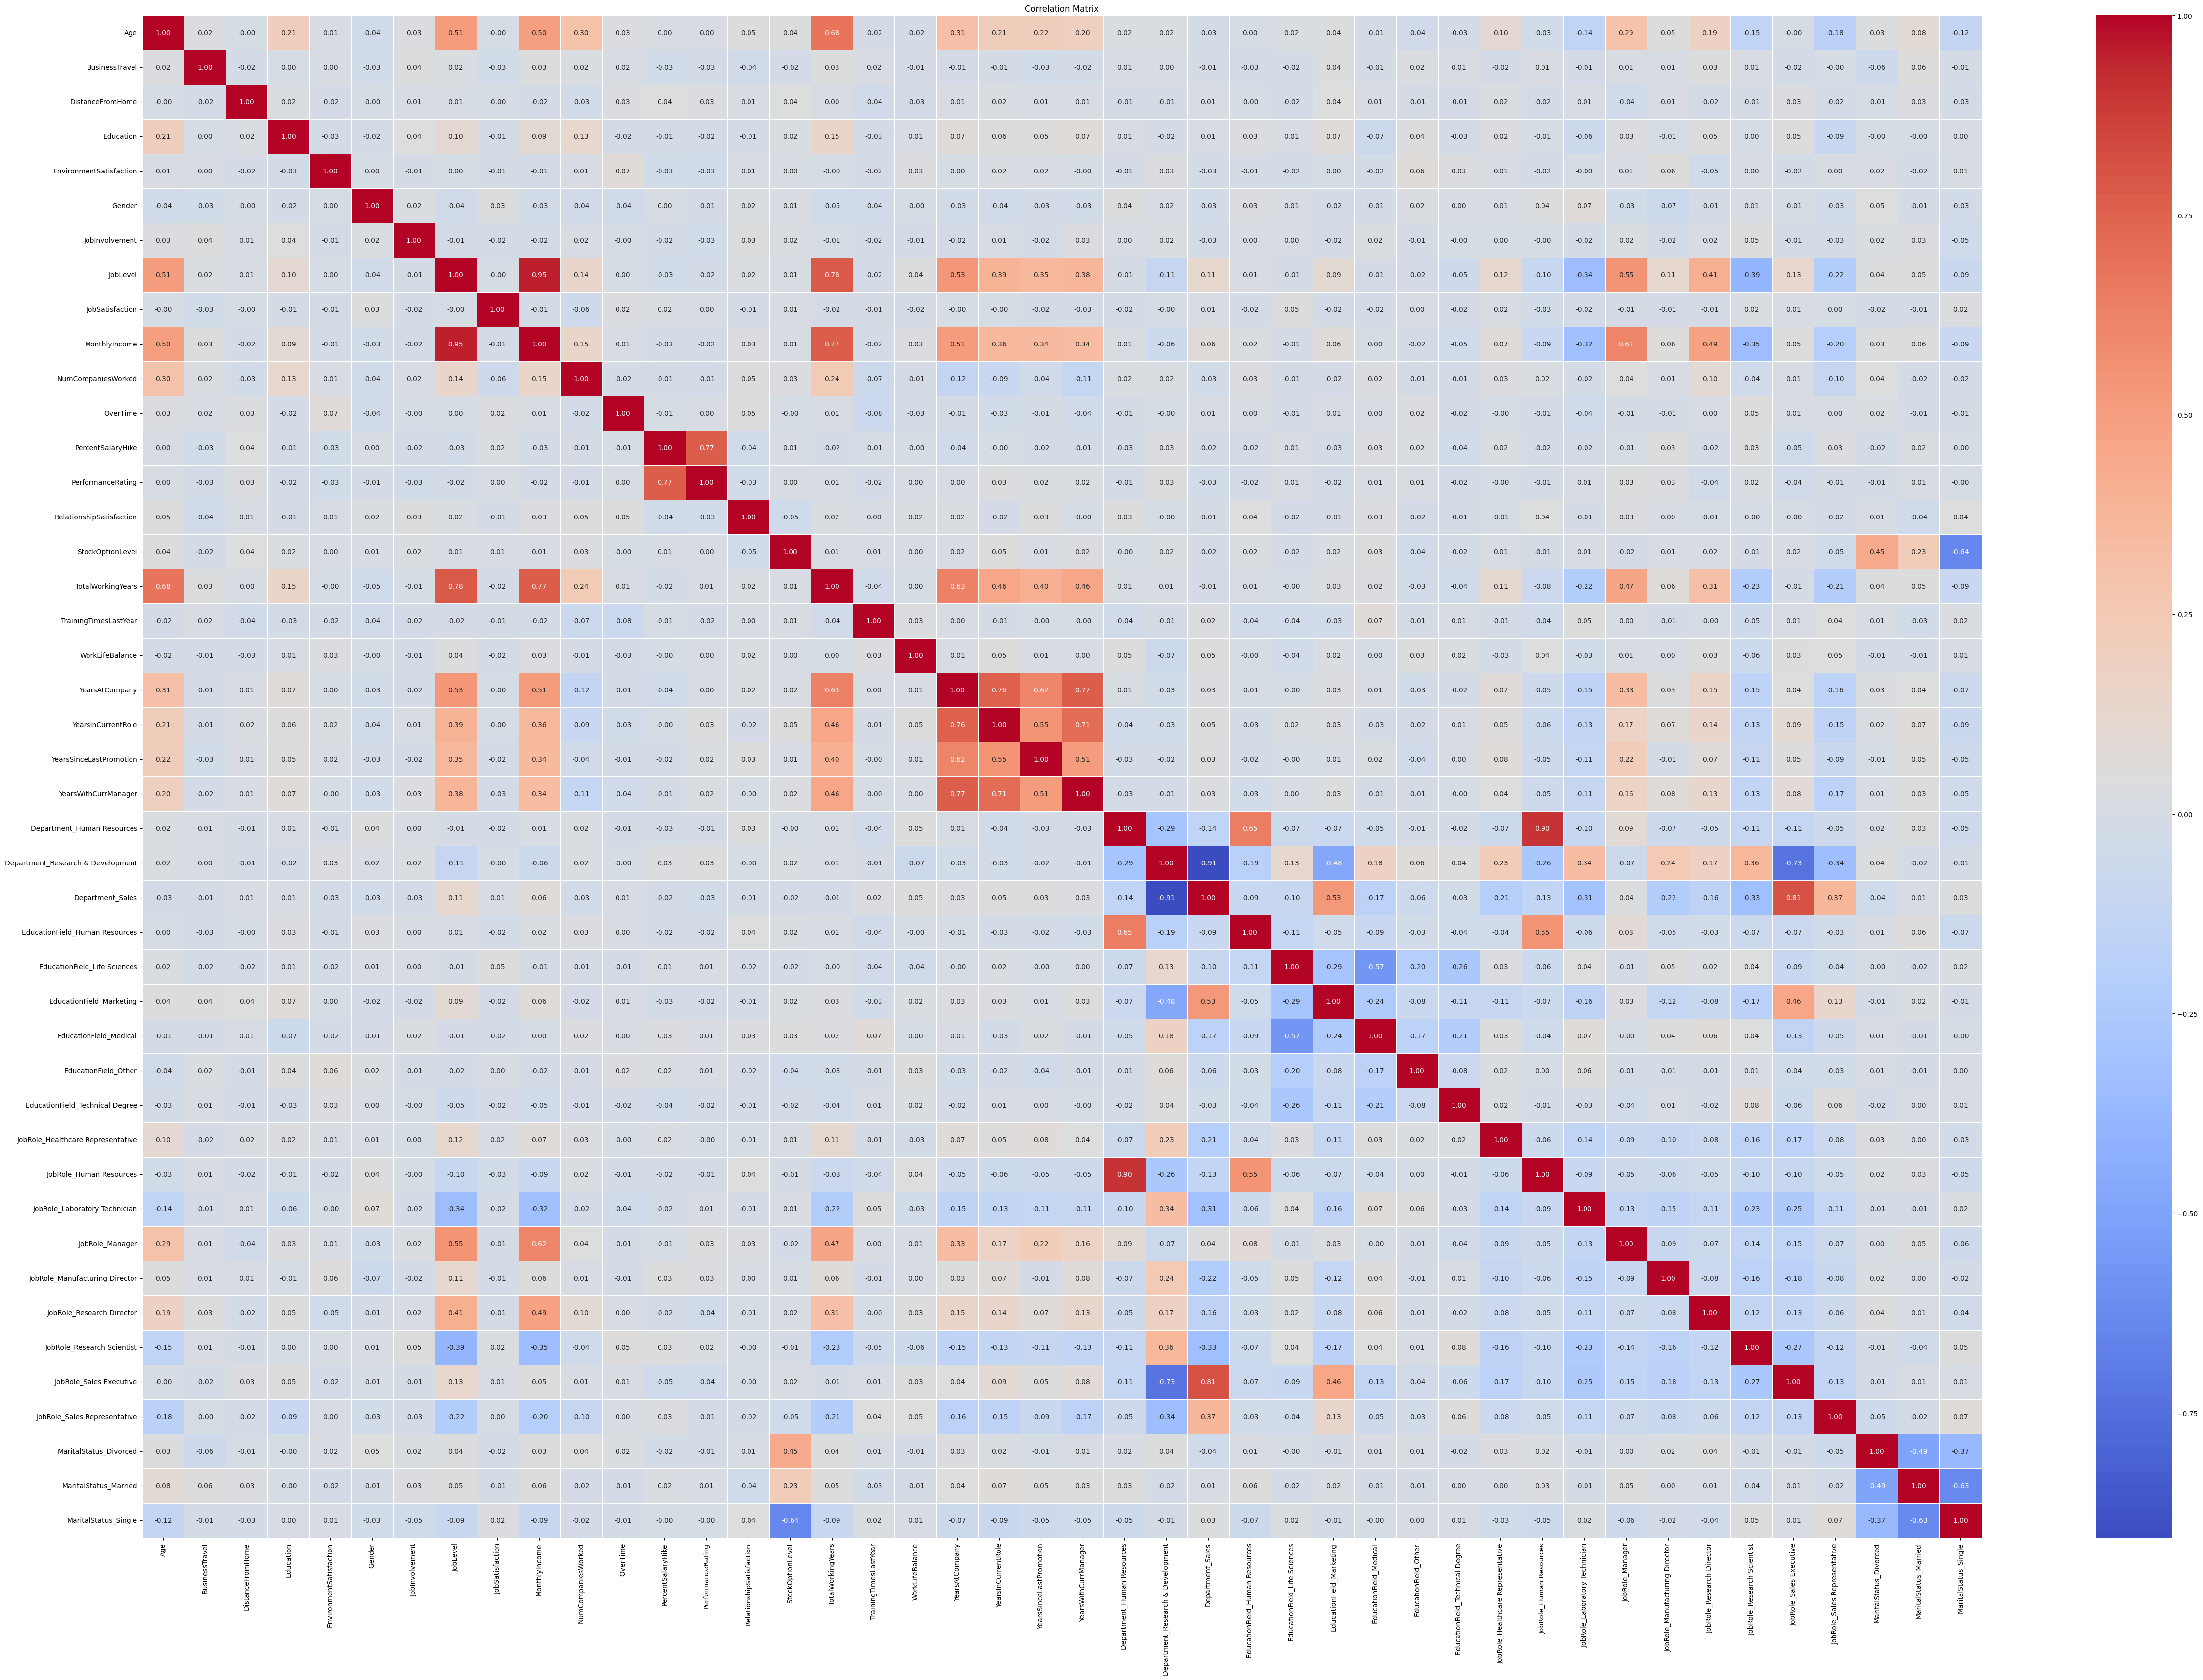

In [ ]:
df_l = df_encoded.drop('Attrition', axis=1)
plt.figure(figsize=(60, 40))
sns.heatmap(df_l.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
hr['BusinessTravel'].value_counts()

,count
BusinessTravel,
2,1043
1,277
0,150


In [ ]:
def correlation_remove(df,threshold):
  corr_col = set()
  corrmat = df.corr()
  for i in range(len(corrmat.columns)):
    for j in range(i):
      if abs(corrmat.iloc[i,j]) > threshold:
        colname = corrmat.columns[i]
        corr_col.add(colname)
  return corr_col

In [ ]:
col1 = correlation_remove(df_l, 0.7)
print(col1)
print(len(col1))

{'MonthlyIncome', 'PerformanceRating', 'YearsWithCurrManager', 'JobRole_Human Resources', 'TotalWorkingYears', 'YearsInCurrentRole', 'JobRole_Sales Executive', 'Department_Sales'}
8


In [ ]:
dfremoved = df_encoded.drop(col1,axis=1)
dfremoved.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'Department_Human Resources',
       'Department_Research & Development', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'JobRole_Healthcare Representative',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Representative',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single'],
      dtyp

## Train-Test Split

Next, let's split the Trainset and Testset. As you can see in the pie chart below, about 84% of all records are currently employed, and only about 16% are former employees. Therefore, we can say that there is an imbalanced class issue.

Attrition
0    1233
1     237
Name: count, dtype: int64


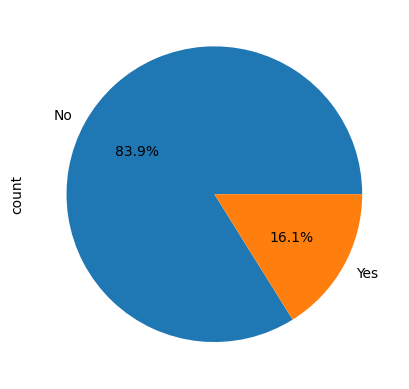

In [ ]:
import matplotlib.pyplot as plt
y = dfremoved['Attrition']
counts = y.value_counts()
print(counts)
counts.plot(kind='pie', labels=['No', 'Yes'], autopct='%1.1f%%')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = dfremoved.drop('Attrition', axis=1)

# split dataset into train, dev, and test sets
# balanced sampling with respect to y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1123, stratify = y)

print("***Train count*** \n",y_train.value_counts())
print("***Test count*** \n",y_test.value_counts())

***Train count*** 
 Attrition
0    863
1    166
Name: count, dtype: int64
***Test count*** 
 Attrition
0    370
1     71
Name: count, dtype: int64


# XGBoost with Oversampling

Oversampling is one method that can be applied to the imbalanced class issue. In oversampling, a portion of the majority class (the class with more records) is removed from a classification dataset with a skewed class distribution. In this case, undersampling should be applied only to the trainset, not the testset. Oversampling has the potential to underfit the model because it risks removing useful data points from the majority class, but it has the advantage of reducing the risk of overfitting and reducing the computational cost. In the code below, you can see that some of the 1110 records of the trainset workers (```Attrition == 0```) were randomly removed through random undersampling, adjusting the class distribution to 50:50.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1123)
X_oversampled, y_oversampled = smote.fit_resample(X_train,y_train)

In [ ]:
X_oversampled.shape[1]

36

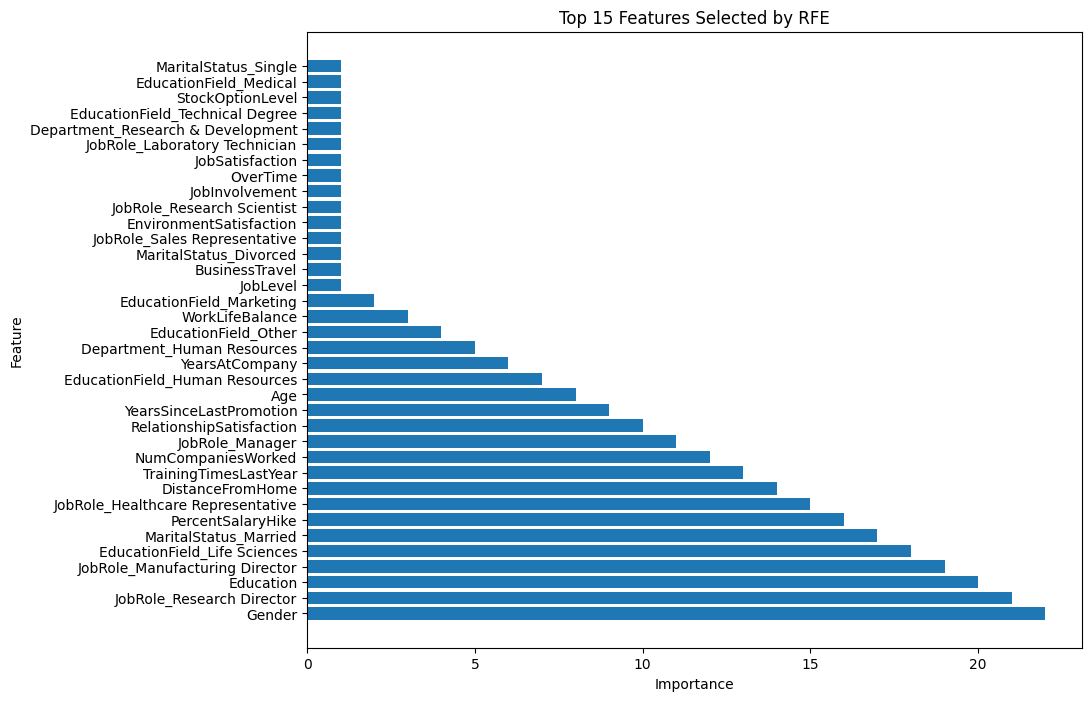

Number of selected features: 15
Top 15 selected features based on RFE: ['BusinessTravel' 'EnvironmentSatisfaction' 'JobInvolvement' 'JobLevel'
 'JobSatisfaction' 'OverTime' 'StockOptionLevel'
 'Department_Research & Development' 'EducationField_Medical'
 'EducationField_Technical Degree' 'JobRole_Laboratory Technician'
 'JobRole_Research Scientist' 'JobRole_Sales Representative'
 'MaritalStatus_Divorced' 'MaritalStatus_Single']


In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=1123, eval_metric='logloss')

# Initialize RFE with the model and select 15 features
rfe = RFE(estimator=xgb, n_features_to_select=15)

# Fit RFE on the oversampled data
rfe.fit(X_oversampled, y_oversampled)

# Get feature rankings from RFE (1 means selected, higher numbers are less important features)
feature_ranks = rfe.ranking_

# Create a DataFrame for visualization with feature importances from RFE
feature_importance_df1 = pd.DataFrame({'Feature': X_oversampled.columns, 'Importance': feature_ranks})
feature_importance_df = feature_importance_df1[feature_importance_df1['Importance'] == 1]
# feature_importance_df['Importance'] = 1  # Mark all selected features as equally important for display

# Sort features for a consistent visualization
feature_importance_df1 = feature_importance_df1.sort_values(by='Importance')
feature_importance_df = feature_importance_df.sort_values(by='Importance')

# Plot selected features from RFE
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df1['Feature'],feature_importance_df1['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Features Selected by RFE')
plt.gca().invert_yaxis()
plt.show()

# Select the top 15 features based on RFE
top_features = feature_importance_df['Feature'].values
X_top = X_oversampled[top_features]

print("Number of selected features:", len(top_features))
print("Top 15 selected features based on RFE:", top_features)


In [ ]:
X_top

,BusinessTravel,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,OverTime,StockOptionLevel,Department_Research & Development,EducationField_Medical,EducationField_Technical Degree,JobRole_Laboratory Technician,JobRole_Research Scientist,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Single
0,1,3,3,3,1,0,1,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,2,4,3,1,3,0,2,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
2,2,4,3,2,2,0,0,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,2,3,3,2,2,1,0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
4,1,2,3,2,2,0,3,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,1,3,3,1,2,0,0,1.000000,0.000000,0.000000,0.0,0.563083,0.000000,0.000000,1.000000
1722,2,2,1,1,1,1,0,1.000000,0.000000,0.159194,1.0,0.000000,0.000000,0.000000,0.159194
1723,1,1,2,2,1,0,2,0.257505,0.257505,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
1724,1,1,2,1,3,0,1,0.000000,0.000000,0.000000,0.0,0.000000,0.483147,0.516853,0.000000


In [ ]:
X_top.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726 entries, 0 to 1725
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   BusinessTravel                     1726 non-null   int64  
 1   EnvironmentSatisfaction            1726 non-null   int64  
 2   JobInvolvement                     1726 non-null   int64  
 3   JobLevel                           1726 non-null   int64  
 4   JobSatisfaction                    1726 non-null   int64  
 5   OverTime                           1726 non-null   int64  
 6   StockOptionLevel                   1726 non-null   int64  
 7   Department_Research & Development  1726 non-null   float64
 8   EducationField_Medical             1726 non-null   float64
 9   EducationField_Technical Degree    1726 non-null   float64
 10  JobRole_Laboratory Technician      1726 non-null   float64
 11  JobRole_Research Scientist         1726 non-null   float

Ranking = 1: These are the most important features according to the model. These features were selected by RFE as they have the highest importance.





Ranking > 1: These are the less important features. They were eliminated during the feature selection process, with higher numbers indicating lower importance.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# Step 1: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_top, y_oversampled, test_size=0.3, random_state=1123, stratify=y_oversampled)

# Step 2: Initialize and train an XGBoost model
xgb_model = XGBClassifier(random_state=1123, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Step 4: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.888030888030888
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       259
           1       0.94      0.83      0.88       259

    accuracy                           0.89       518
   macro avg       0.89      0.89      0.89       518
weighted avg       0.89      0.89      0.89       518

Confusion Matrix:
 [[244  15]
 [ 43 216]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:20:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],

}

# Initialize the model
xgb_model = XGBClassifier(random_state=1123, eval_metric='logloss')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings sampled
    scoring='f1',
    cv=5,  # 3-fold cross-validation
    verbose=1,
    random_state=1123,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best Cross-Validation Accuracy: 0.9049790191951501


In [ ]:
X_top.shape

(1726, 15)

In [ ]:
X_top.columns

Index(['BusinessTravel', 'EnvironmentSatisfaction', 'JobInvolvement',
       'JobLevel', 'JobSatisfaction', 'OverTime', 'StockOptionLevel',
       'Department_Research & Development', 'EducationField_Medical',
       'EducationField_Technical Degree', 'JobRole_Laboratory Technician',
       'JobRole_Research Scientist', 'JobRole_Sales Representative',
       'MaritalStatus_Divorced', 'MaritalStatus_Single'],
      dtype='object')

In [ ]:
X_top.info

<bound method DataFrame.info of       BusinessTravel  EnvironmentSatisfaction  JobInvolvement  JobLevel  \
0                  1                        3               3         3   
1                  2                        4               3         1   
2                  2                        4               3         2   
3                  2                        3               3         2   
4                  1                        2               3         2   
...              ...                      ...             ...       ...   
1721               1                        3               3         1   
1722               2                        2               1         1   
1723               1                        1               2         2   
1724               1                        1               2         1   
1725               0                        2               3         1   

      JobSatisfaction  OverTime  StockOptionLevel  \
0                   1         0                 1   
1                   3         0                 2   
2                   2         0                 0   
3                   2         1                 0   
4                   2         0                 3   
...               ...       ...               ...   
1721                2         0                 0   
1722                1         1                 0   
1723                1         0                 2   
1724                3         0                 1   
1725                1         0                 0   

      Department_Research & Development  EducationField_Medical  \
0                              1.000000                0.000000   
1                              1.000000                1.000000   
2                              1.000000                1.000000   
3                              1.000000                0.000000   
4                              0.000000                1.000000   
...                                 ...                     ...   
1721                           1.000000                0.000000   
1722                           1.000000                0.000000   
1723                           0.257505                0.257505   
1724                           0.000000                0.000000   
1725                           0.000000                0.026245   

      EducationField_Technical Degree  JobRole_Laboratory Technician  \
0                            0.000000                            0.0   
1                            0.000000                            0.0   
2                            0.000000                            0.0   
3                            0.000000                            0.0   
4                            0.000000                            0.0   
...                               ...                            ...   
1721                         0.000000                            0.0   
1722                         0.159194                            1.0   
1723                         0.000000                            0.0   
1724                         0.000000                            0.0   
1725                         0.973755                            0.0   

      JobRole_Research Scientist  JobRole_Sales Representative  \
0                       0.000000                      0.000000   
1                       1.000000                      0.000000   
2                       0.000000                      0.000000   
3                       0.000000                      0.000000   
4                       0.000000                      0.000000   
...                          ...                           ...   
1721                    0.563083                      0.000000   
1722                    0.000000                      0.000000   
1723                    0.000000                      0.000000   
1724                    0.000000                      0.483147   
1725                    0.000000  

In [ ]:
# Train the XGBoost model with the best parameters
xgb_best = XGBClassifier(**best_params, random_state=1123, eval_metric='logloss')
xgb_best.fit(X_train, y_train)
xgb_best.save_model('xgb_best.json')
# Evaluate on test set
y_pred = xgb_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy with Tuned Model:", accuracy)


Test Set Accuracy with Tuned Model: 0.8918918918918919


In [ ]:
y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,

In [ ]:
sample_value = X_top.iloc[[100]]
prediction = xgb_best.predict(sample_value)
prediction[0]

0

0 - Stay
1 - Attrition

In [ ]:
import joblib
joblib.dump(X_top, 'X_top.pkl')

['X_top.pkl']

Saving X_top values to use in development server

# LIME

Next, let’s see what explanation the model can provide for a random leaver. LIME is a type of XAI method that provides local explanations for the classification of individual records. The core idea of ​​LIME is to create a local linear regression model that can explain a specific record of interest and explain why the model classified that record. When using LIME, the following steps are usually taken:

 1. Sampling and surrogate data generation: Sample data around the record you want to explain to create a surrogate data set that can explain that record.
 2. Sparse linear model training: Fit a linear model to the surrogate data set using L1 regularization.
 3. Sparse linear model interpretation: Use a linear model to explain the predictions of the original model in terms of the features of the original instance.
   
Here, surrogate data refers to an artificially generated set of data points that are used to train a simpler local model. Surrogate data generation involves augmenting the original data to create data points with new target labels. Therefore, the LIME model creates a dataset with feature values ​​similar to the data points of interest, and then fits a linear model to the dataset to provide explanatory power through regression coefficients.

Let's look at record 415 randomly from the entire dataset. This record is the data of an employee who actually resigned, and the model accurately classified the employee's resignation.

In [ ]:
# Import LIME
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=45b46be1b48331c1e024fdbbcabbad2dd0e187693a89194ecd645e5e10bde94d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
anon_pred = xgb_best.predict(X_top.iloc[[100]])
anon_attrition = y.iloc[100]

# print predicted label and true label for the instance
print("Predicted label:", anon_pred[0])
print("True label:", anon_attrition)

Predicted label: 0
True label: 1


In [ ]:
import lime
import lime.lime_tabular

# Initialize a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_top.values,
    feature_names=top_features,
    class_names=['stay','leave'],
    mode='classification',
)

# Explain a single prediction
instance_idx = 100  # Change this index to explain different instances
instance = X_top.iloc[instance_idx]
exp = explainer.explain_instance(
  instance.values,
  xgb_best.predict_proba,
  num_features=len(top_features),
  num_samples=5000
)


In [ ]:
print(exp.as_list())

[('MaritalStatus_Single <= 0.00', -0.1794049877811746), ('Department_Research & Development <= 0.00', -0.14424847177038785), ('EducationField_Medical <= 0.00', -0.09417757928824928), ('MaritalStatus_Divorced > 0.00', 0.088543857511309), ('EducationField_Technical Degree <= 0.00', -0.07154137453411492), ('0.00 < StockOptionLevel <= 1.00', -0.060691465875019696), ('JobSatisfaction <= 2.00', 0.060149817090128316), ('OverTime <= 0.00', -0.058009803092334424), ('JobRole_Research Scientist <= 0.00', -0.049329731391048875), ('JobInvolvement <= 2.00', 0.04779195468664498), ('JobLevel > 2.00', -0.04569382424557239), ('JobRole_Laboratory Technician <= 0.00', -0.03817829589447278), ('JobRole_Sales Representative <= 0.00', -0.0313639106467789), ('1.00 < EnvironmentSatisfaction <= 3.00', 0.02892767412335154), ('1.00 < BusinessTravel <= 2.00', -0.025317250916739552)]


In [ ]:
print(f"LIME explanation for employee at index {instance_idx}:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight}")

LIME explanation for employee at index 100:
MaritalStatus_Single <= 0.00: -0.1794049877811746
Department_Research & Development <= 0.00: -0.14424847177038785
EducationField_Medical <= 0.00: -0.09417757928824928
MaritalStatus_Divorced > 0.00: 0.088543857511309
EducationField_Technical Degree <= 0.00: -0.07154137453411492
0.00 < StockOptionLevel <= 1.00: -0.060691465875019696
JobSatisfaction <= 2.00: 0.060149817090128316
OverTime <= 0.00: -0.058009803092334424
JobRole_Research Scientist <= 0.00: -0.049329731391048875
JobInvolvement <= 2.00: 0.04779195468664498
JobLevel > 2.00: -0.04569382424557239
JobRole_Laboratory Technician <= 0.00: -0.03817829589447278
JobRole_Sales Representative <= 0.00: -0.0313639106467789
1.00 < EnvironmentSatisfaction <= 3.00: 0.02892767412335154
1.00 < BusinessTravel <= 2.00: -0.025317250916739552


In [ ]:
exp.show_in_notebook(show_table=True)

In conclusion,overtime and Education field medical are the strongest influences on the prediction that employee 100 will stay.

# SHAP
## Shapley Value and Cooperative Games

Cooperative games are a field of game theory, where players form a coalition to achieve a common goal. In a cooperative game, the cooperative outcome for each possible combination of each member is measured, and the marginal contribution and Shapley value of each player are calculated to calculate the contribution of each player in actual teamwork. In machine learning, the concept of marginal contribution and Shapley value can be applied to measure how features affect the outcome within a model. For example, let's say we have a "black box model" with three features, x1, x2, and x3. This model makes predictions for each possible combination of features. In this model, the marginal contribution and Shapley value of each feature are measured based on the predicted outcome of each model.

|Model|x1|x2|x3|Outcome|
|---|---|---|---|---|
|m1|False|False|False|28| |m2|True|False|False|32|
|m3|False|True|False|31|
|m4|False|False|True|30|
|m5|True|True|False|32|
|m6|True|False|True|33|
|m7|False|True|True|32|
|m8|True|True|True|35|

Let's look at the marginal contribution of x1. In the model with only one feature, the difference in the results of m2 with x1 and m1 without x1 is 4, so the marginal contribution of x1 in the model with only one feature is 4. Next, there are two dual-feature models with x1 (m5 and m6). If we exclude x1 from m5, we get m3, and the difference in the results is 32-31=1. Similarly, if we exclude x1 from m6, the result will be 3 different. Finally, if we exclude x1 from the entire model m8, the result will be 3 different. This can be obtained by subtracting the result of m7 from the result of m8. Therefore, the marginal contribution of x1 is as follows.

* Single feature model: m2 - m1 = 4
* Dual feature model: m5 - m3 = 1
* Dual feature model: m6 - m4 = 3
* Triple feature model: m8 - m7 = 3

From the marginal contribution of x1 in each case, we can obtain the Shapley value through a weighted sum. For example, among the three single feature models, only one can exclude x1. Therefore, the weight for the margin contribution of x1 in the single feature model is 1/3. Similarly, there are three dual feature models in total, and each model can exclude one of the two features. In this case, the weight for the margin contribution of x1 is 1/6. That is, since there are 3 models and 2 possible exclusions within each model, it is $1/3 \times 1/2$. Finally, there is only 1 overall model and there are 3 possible exclusions within the model. Therefore, the weight is $1 \times 1/3$. Therefore, the Shapley value of feature x1 is:

$$
4 \ast \frac{1}{3} + 1 \ast \frac{1}{6} + 3 \ast \frac{1}{6} + 3 \ast \frac{1}{3}
$$

In [ ]:
# Import SHAP
import shap

# Set up the SHAP Explainer

feature_names = top_features
shap_explainer = shap.Explainer(xgb_best, X_top)
shap_values = shap_explainer(X_top)

shap_values.shape

 98%|===================| 1687/1726 [00:11<00:00]       

(1726, 15)

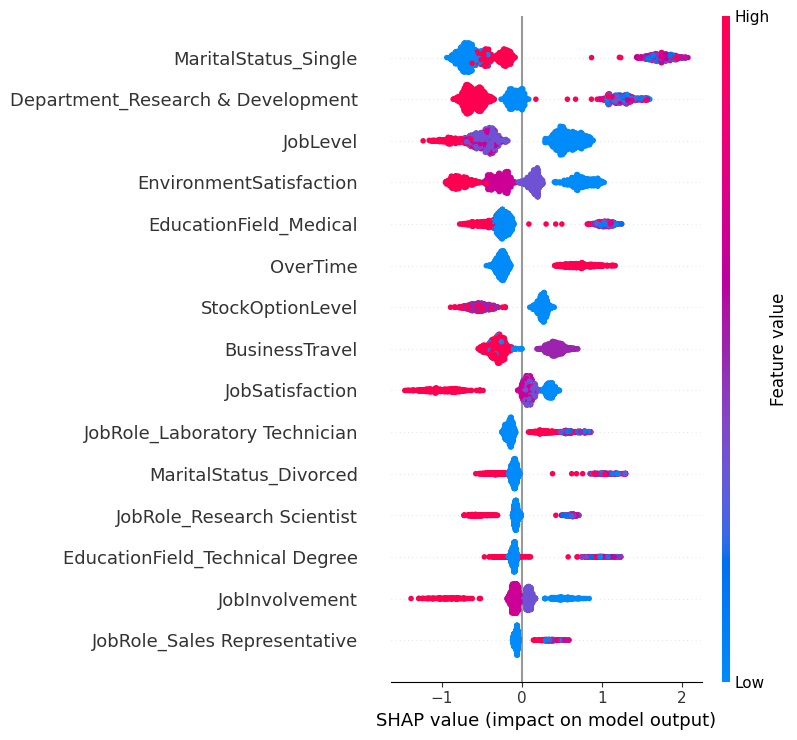

In [ ]:
# SHAP Summary Plot (Global interpretation)
shap.summary_plot(shap_values, X_top, feature_names=top_features)

This plot shows the global feature importance across the dataset. Features like MaritalStatus_Single, Department_Research & Development, and Age have significant impact on predictions.


MaritalStatus_Single with high values (single employees) tends to increase the likelihood of leaving.


Employees in Department_Research & Development also have notable impacts on the model output, possibly influencing both staying and leaving based on their position within the distribution.

In [ ]:
shap_values[415]

.values =
array([-0.22703966,  0.63984754, -0.0821697 ,  0.73286096,  0.34446529,
       -0.27259996,  0.23267771, -0.47872649, -0.63566008, -0.12060744,
        0.31003826, -0.06955722, -0.04809303, -0.09144881, -0.2637571 ])

.base_values =
0.9703610390348695

.data =
array([2., 1., 3., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.])

SHAP for single employee

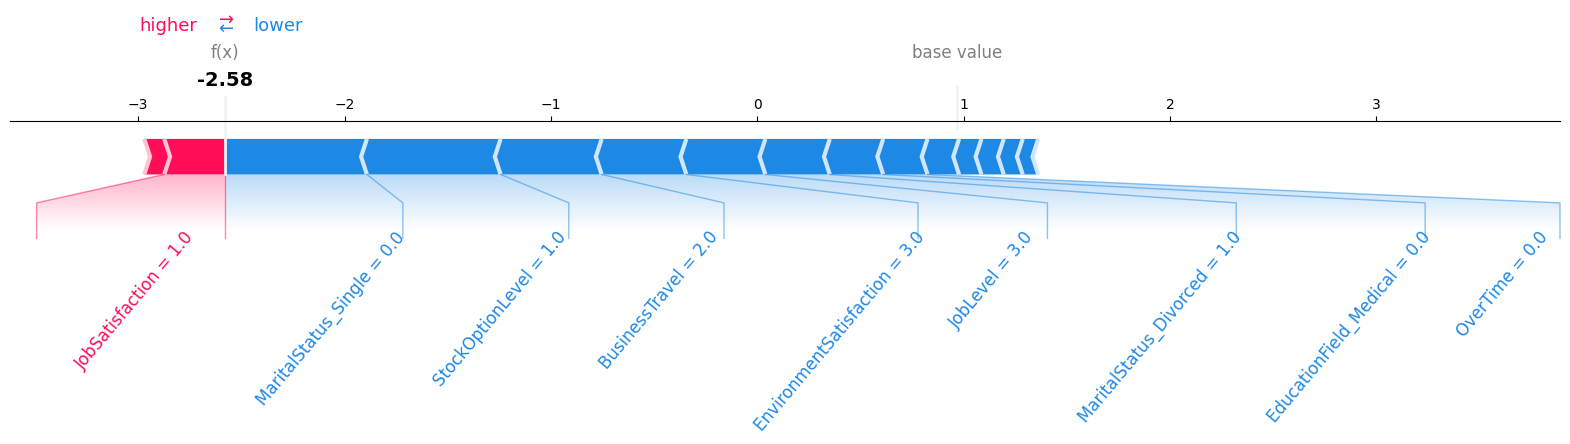

In [ ]:
from IPython.core.display import HTML
import matplotlib.pyplot as plt

def initjs():
    display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/codemirror/5.13.4/codemirror.min.js'></script>"))

# create Explanation object for the instance at index 100
inst = X_top.iloc[100]
exp_value = shap_explainer.expected_value
shap_values_inst = shap_explainer(inst)
explanation = shap.Explanation(values = shap_values[100].values, # shapley values
                               base_values = shap_explainer.expected_value, # baseline
                               data = X_top.iloc[100],
                               feature_names = feature_names)

# call initjs() before using shap.force_plot()
initjs()
shap.force_plot(explanation.base_values,
                shap_values[100].values,
                inst,
                feature_names = explanation.feature_names,
                matplotlib = True,
                text_rotation = 50)

Looking at the graph above, we can see that factors that may have made the employee decide to leave include job satisfaction while conversely, education field medical and overtime role research was a factor that may have made them hesitate to leave for employee at index 100.